# LSTM Poker Agent with PokerKit - FIXED VERSION

This notebook implements a Deep Recurrent Q-Network (DRQN) agent for No-Limit Texas Hold'em.

## Fixes Applied:
- **Epsilon decay per HAND** (not per session) - faster learning
- **epsilon_min: 0.05** (was 0.1) - more exploitation
- **epsilon_decay: 0.9995** per hand (was 0.995 per session)
- **Training: 100 sessions x 100 hands = 10,000 hands** (was 1,000)

In [1]:
# Cell 1: Dependencies & Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import random
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List, Dict, Any

from pokerkit import Automation, NoLimitTexasHoldem, Card

# Constants
MAX_HISTORY_LEN = 20
SEED = 42

# Set random seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Cell 2: Action Encoding

# Action tokens for history encoding
ACTION_FOLD = 0
ACTION_CHECK_CALL = 1
ACTION_BET_RAISE = 2
ACTION_PAD = 3  # For padding shorter sequences
NUM_ACTION_TOKENS = 4

# Environment action space
ENV_FOLD = 0
ENV_CHECK_CALL = 1
ENV_BET_RAISE = 2
NUM_ACTIONS = 3

In [3]:
# Cell 3: Custom Gym Wrapper for PokerKit

class PokerKitGymEnv(gym.Env):
    """
    Gymnasium wrapper for PokerKit's No-Limit Texas Hold'em.
    """
    
    def __init__(self, num_players: int = 2, starting_stack: int = 1000, 
                 small_blind: int = 5, big_blind: int = 10):
        super().__init__()
        
        self.num_players = num_players
        self.starting_stack = starting_stack
        self.small_blind = small_blind
        self.big_blind = big_blind
        
        self.game_state_dim = 104 + 260 + num_players + 1 + 1 + 4
        
        self.observation_space = spaces.Dict({
            'game_state': spaces.Box(low=0, high=1, shape=(self.game_state_dim,), dtype=np.float32),
            'action_history': spaces.Box(low=0, high=NUM_ACTION_TOKENS-1, 
                                         shape=(MAX_HISTORY_LEN,), dtype=np.int64)
        })
        
        self.action_space = spaces.Discrete(NUM_ACTIONS)
        
        self.state = None
        self.action_history = deque(maxlen=MAX_HISTORY_LEN)
        self.agent_player_index = 0
        
    def _card_to_index(self, card: Card) -> int:
        ranks = '23456789TJQKA'
        suits = 'cdhs'
        rank_idx = ranks.index(card.rank)
        suit_idx = suits.index(card.suit)
        return rank_idx * 4 + suit_idx
    
    def _encode_card(self, card: Optional[Card]) -> np.ndarray:
        encoding = np.zeros(52, dtype=np.float32)
        if card is not None:
            encoding[self._card_to_index(card)] = 1.0
        return encoding
    
    def _flatten_cards(self, cards) -> List:
        flat = []
        for item in cards:
            if hasattr(item, 'rank'):
                flat.append(item)
            else:
                flat.extend(self._flatten_cards(item))
        return flat
    
    def _get_game_state(self) -> np.ndarray:
        state_vector = []
        
        hole_cards = self._flatten_cards(self.state.hole_cards[self.agent_player_index])
        for i in range(2):
            if i < len(hole_cards):
                state_vector.extend(self._encode_card(hole_cards[i]))
            else:
                state_vector.extend(np.zeros(52, dtype=np.float32))
        
        board_cards = self._flatten_cards(self.state.board_cards)
        for i in range(5):
            if i < len(board_cards):
                state_vector.extend(self._encode_card(board_cards[i]))
            else:
                state_vector.extend(np.zeros(52, dtype=np.float32))
        
        for i in range(self.num_players):
            stack = self.state.stacks[i] / self.starting_stack
            state_vector.append(min(stack, 2.0))
        
        total_pot = sum(self.state.bets)
        state_vector.append(total_pot / (self.starting_stack * self.num_players))
        
        if self.state.actor_index is not None:
            state_vector.append(self.state.actor_index / (self.num_players - 1))
        else:
            state_vector.append(0.0)
        
        street = [0.0, 0.0, 0.0, 0.0]
        num_board = len(board_cards)
        if num_board == 0:
            street[0] = 1.0
        elif num_board == 3:
            street[1] = 1.0
        elif num_board == 4:
            street[2] = 1.0
        else:
            street[3] = 1.0
        state_vector.extend(street)
        
        return np.array(state_vector, dtype=np.float32)
    
    def _get_action_history(self) -> np.ndarray:
        history = list(self.action_history)
        while len(history) < MAX_HISTORY_LEN:
            history.insert(0, ACTION_PAD)
        return np.array(history[-MAX_HISTORY_LEN:], dtype=np.int64)
    
    def _get_observation(self) -> Dict[str, np.ndarray]:
        return {
            'game_state': self._get_game_state(),
            'action_history': self._get_action_history()
        }
    
    def _get_legal_actions(self) -> List[int]:
        legal = []
        if self.state.can_fold():
            legal.append(ENV_FOLD)
        if self.state.can_check_or_call():
            legal.append(ENV_CHECK_CALL)
        if self.state.can_complete_bet_or_raise_to():
            legal.append(ENV_BET_RAISE)
        return legal if legal else [ENV_CHECK_CALL]
    
    def _execute_action(self, action: int) -> None:
        if action == ENV_FOLD:
            if self.state.can_fold():
                self.state.fold()
            elif self.state.can_check_or_call():
                self.state.check_or_call()
        elif action == ENV_CHECK_CALL:
            if self.state.can_check_or_call():
                self.state.check_or_call()
            elif self.state.can_fold():
                self.state.fold()
        elif action == ENV_BET_RAISE:
            if self.state.can_complete_bet_or_raise_to():
                min_raise = self.state.min_completion_betting_or_raising_to_amount
                max_raise = self.state.max_completion_betting_or_raising_to_amount
                raise_amount = min(min_raise * 2, max_raise)
                self.state.complete_bet_or_raise_to(raise_amount)
            elif self.state.can_check_or_call():
                self.state.check_or_call()
    
    def _run_automations(self) -> None:
        while self.state.can_burn_card():
            self.state.burn_card('??')
        while self.state.can_deal_board():
            self.state.deal_board()
        while self.state.can_push_chips():
            self.state.push_chips()
        while self.state.can_pull_chips():
            self.state.pull_chips()
    
    def _action_to_token(self, action: int) -> int:
        if action == ENV_FOLD:
            return ACTION_FOLD
        elif action == ENV_CHECK_CALL:
            return ACTION_CHECK_CALL
        else:
            return ACTION_BET_RAISE
    
    def reset(self, seed=None, options=None) -> Tuple[Dict[str, np.ndarray], Dict]:
        super().reset(seed=seed)
        
        self.state = NoLimitTexasHoldem.create_state(
            automations=(
                Automation.ANTE_POSTING,
                Automation.BET_COLLECTION,
                Automation.BLIND_OR_STRADDLE_POSTING,
                Automation.HOLE_CARDS_SHOWING_OR_MUCKING,
                Automation.HAND_KILLING,
                Automation.CHIPS_PUSHING,
                Automation.CHIPS_PULLING,
            ),
            ante_trimming_status=True,
            raw_antes={-1: 0},
            raw_blinds_or_straddles=(self.small_blind, self.big_blind),
            min_bet=self.big_blind,
            raw_starting_stacks=[self.starting_stack] * self.num_players,
            player_count=self.num_players,
        )
        
        while self.state.can_deal_hole():
            self.state.deal_hole()
        
        self._run_automations()
        
        return self._get_observation(), {'legal_actions': self._get_legal_actions()}
    
    def reset_session(self) -> None:
        self.action_history.clear()
    
    def step(self, action: int) -> Tuple[Dict[str, np.ndarray], float, bool, bool, Dict]:
        current_player = self.state.actor_index
        
        if current_player != self.agent_player_index:
            self.action_history.append(self._action_to_token(action))
        
        self._execute_action(action)
        self._run_automations()
        
        done = self.state.status is False
        
        reward = 0.0
        if done:
            final_stack = self.state.stacks[self.agent_player_index]
            reward = (final_stack - self.starting_stack) / self.big_blind
        
        obs = self._get_observation()
        info = {
            'legal_actions': self._get_legal_actions() if not done else [],
            'current_player': self.state.actor_index if not done else None
        }
        
        return obs, reward, done, False, info
    
    def get_current_player(self) -> Optional[int]:
        if self.state.status is False:
            return None
        return self.state.actor_index

In [4]:
# Cell 4: Sequence Replay Buffer

class SequenceReplayBuffer:
    """Replay buffer that stores full episodes with session information."""
    
    def __init__(self, capacity: int = 5000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, episode: List[Tuple], initial_hidden: Tuple[torch.Tensor, torch.Tensor]):
        self.buffer.append((episode, initial_hidden))
    
    def sample(self, batch_size: int):
        batch = random.sample(list(self.buffer), min(batch_size, len(self.buffer)))
        return batch
    
    def __len__(self):
        return len(self.buffer)

In [5]:
# Cell 5: Dual-Input Agent Model

class DualInputAgent(nn.Module):
    """DRQN Agent with dual-input architecture."""
    
    def __init__(self, game_state_dim: int, action_vocab_size: int = NUM_ACTION_TOKENS,
                 hidden_dim: int = 128, embed_dim: int = 32, num_actions: int = NUM_ACTIONS):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        # MLP Branch for game state
        self.mlp = nn.Sequential(
            nn.Linear(game_state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, hidden_dim),
            nn.ReLU()
        )
        
        # LSTM Branch for action history
        self.action_embedding = nn.Embedding(action_vocab_size, embed_dim, padding_idx=ACTION_PAD)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, 
                           num_layers=1, batch_first=True)
        
        # Output head
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
    
    def forward(self, game_state: torch.Tensor, history_seq: torch.Tensor, 
                hidden: Optional[Tuple[torch.Tensor, torch.Tensor]] = None) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        batch_size = game_state.size(0)
        
        mlp_out = self.mlp(game_state)
        action_embeds = self.action_embedding(history_seq)
        
        if hidden is None:
            hidden = self.init_hidden(batch_size, game_state.device)
        
        lstm_out, new_hidden = self.lstm(action_embeds, hidden)
        lstm_out = lstm_out[:, -1, :]
        
        combined = torch.cat([mlp_out, lstm_out], dim=1)
        q_values = self.output_head(combined)
        
        return q_values, new_hidden
    
    def init_hidden(self, batch_size: int, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
        h = torch.zeros(1, batch_size, self.hidden_dim, device=device)
        c = torch.zeros(1, batch_size, self.hidden_dim, device=device)
        return (h, c)

In [6]:
# Cell 6: Fixed-Strategy Opponents

class ManiacAgent:
    """Always raises/bets when possible, otherwise calls."""
    
    def select_action(self, legal_actions: List[int]) -> int:
        if ENV_BET_RAISE in legal_actions:
            return ENV_BET_RAISE
        if ENV_CHECK_CALL in legal_actions:
            return ENV_CHECK_CALL
        return ENV_FOLD


class NitAgent:
    """Always folds when facing aggression, checks/calls otherwise."""
    
    def __init__(self):
        self.facing_raise = False
    
    def select_action(self, legal_actions: List[int]) -> int:
        if ENV_FOLD in legal_actions and ENV_CHECK_CALL in legal_actions:
            if random.random() < 0.8:
                return ENV_FOLD
        if ENV_CHECK_CALL in legal_actions:
            return ENV_CHECK_CALL
        return ENV_FOLD


class RandomAgent:
    """Randomly selects from legal actions."""
    
    def select_action(self, legal_actions: List[int]) -> int:
        return random.choice(legal_actions)

In [7]:
# Cell 7: Agent Wrapper with Epsilon-Greedy - FIXED VERSION

class DRQNAgentWrapper:
    """
    Wrapper for training the DualInputAgent with DQN.
    
    FIXED: Epsilon decay now happens per hand, not per session.
    """
    
    def __init__(self, game_state_dim: int, hidden_dim: int = 128,
                 lr: float = 1e-3, gamma: float = 0.99,
                 epsilon_start: float = 1.0, epsilon_min: float = 0.05,  # FIXED: lower min
                 epsilon_decay: float = 0.9995):  # FIXED: per-hand decay rate
        
        self.model = DualInputAgent(game_state_dim, hidden_dim=hidden_dim).to(device)
        self.target_model = DualInputAgent(game_state_dim, hidden_dim=hidden_dim).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        self.current_hidden = None
    
    def start_new_session(self):
        self.current_hidden = None
        print("[Session Reset] LSTM hidden state cleared.")
    
    def get_hidden_for_episode(self) -> Tuple[torch.Tensor, torch.Tensor]:
        if self.current_hidden is None:
            return self.model.init_hidden(1, device)
        return (self.current_hidden[0].clone(), self.current_hidden[1].clone())
    
    def select_action(self, obs: Dict[str, np.ndarray], legal_actions: List[int],
                      eval_mode: bool = False) -> int:
        if not eval_mode and random.random() < self.epsilon:
            return random.choice(legal_actions)
        
        game_state = torch.FloatTensor(obs['game_state']).unsqueeze(0).to(device)
        history = torch.LongTensor(obs['action_history']).unsqueeze(0).to(device)
        
        with torch.no_grad():
            q_values, self.current_hidden = self.model(game_state, history, self.current_hidden)
        
        q_values = q_values[0].cpu().numpy()
        masked_q = np.full(NUM_ACTIONS, -np.inf)
        for a in legal_actions:
            masked_q[a] = q_values[a]
        
        return int(np.argmax(masked_q))
    
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def train_step(self, buffer: SequenceReplayBuffer, batch_size: int = 32) -> Optional[float]:
        if len(buffer) < batch_size:
            return None
        
        batch = buffer.sample(batch_size)
        total_loss = 0.0
        num_transitions = 0
        
        for episode, initial_hidden in batch:
            if len(episode) == 0:
                continue
            
            hidden = (initial_hidden[0].to(device), initial_hidden[1].to(device))
            
            for obs, action, reward, next_obs, done, legal_actions in episode:
                game_state = torch.FloatTensor(obs['game_state']).unsqueeze(0).to(device)
                history = torch.LongTensor(obs['action_history']).unsqueeze(0).to(device)
                
                q_values, hidden = self.model(game_state, history, hidden)
                q_value = q_values[0, action]
                
                if done:
                    target = reward
                else:
                    next_game_state = torch.FloatTensor(next_obs['game_state']).unsqueeze(0).to(device)
                    next_history = torch.LongTensor(next_obs['action_history']).unsqueeze(0).to(device)
                    
                    with torch.no_grad():
                        next_q_values, _ = self.target_model(next_game_state, next_history, hidden)
                        target = reward + self.gamma * next_q_values.max().item()
                
                loss = F.mse_loss(q_value, torch.tensor(target, device=device))
                total_loss += loss
                num_transitions += 1
        
        if num_transitions > 0:
            avg_loss = total_loss / num_transitions
            
            self.optimizer.zero_grad()
            avg_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            
            return avg_loss.item()
        
        return None

In [8]:
# Cell 8: Training Loop - FIXED VERSION
"""
CRITICAL FIXES:
1. Epsilon decay per HAND (not per session)
2. More training iterations (10,000 hands instead of 1,000)
"""

def train_agent(num_sessions: int = 100, hands_per_session: int = 100,
                batch_size: int = 16, target_update_freq: int = 10):
    """
    Train the DRQN agent with session-based LSTM state management.
    FIXED: Epsilon now updates per hand, not per session.
    """
    
    env = PokerKitGymEnv(num_players=2)
    agent = DRQNAgentWrapper(game_state_dim=env.game_state_dim)
    buffer = SequenceReplayBuffer(capacity=5000)
    
    opponents = {
        'maniac': ManiacAgent(),
        'nit': NitAgent(),
        'random': RandomAgent()
    }
    
    rewards_history = []
    session_rewards = []
    
    print("Starting training...")
    print(f"Sessions: {num_sessions}, Hands per session: {hands_per_session}")
    print(f"Total hands: {num_sessions * hands_per_session}")
    print()
    
    for session in range(num_sessions):
        if session < num_sessions // 2:
            opponent_name = 'maniac'
        else:
            opponent_name = 'nit'
        
        opponent = opponents[opponent_name]
        
        agent.start_new_session()
        env.reset_session()
        
        session_reward = 0.0
        
        for hand in range(hands_per_session):
            initial_hidden = agent.get_hidden_for_episode()
            obs, info = env.reset()
            episode_transitions = []
            done = False
            
            while not done:
                current_player = env.get_current_player()
                legal_actions = info['legal_actions']
                
                if current_player is None:
                    break
                
                if current_player == env.agent_player_index:
                    action = agent.select_action(obs, legal_actions)
                    next_obs, reward, done, truncated, info = env.step(action)
                    
                    episode_transitions.append((
                        obs, action, reward, next_obs, done,
                        info.get('legal_actions', [])
                    ))
                    
                    obs = next_obs
                else:
                    opp_action = opponent.select_action(legal_actions)
                    obs, reward, done, truncated, info = env.step(opp_action)
            
            if episode_transitions:
                buffer.push(episode_transitions, initial_hidden)
                
                final_reward = episode_transitions[-1][2]
                rewards_history.append(final_reward)
                session_reward += final_reward
            
            # Train
            if len(buffer) >= batch_size:
                agent.train_step(buffer, batch_size)
            
            # FIXED: Update epsilon after each hand (not session)
            agent.update_epsilon()
        
        # Update target network
        if session % target_update_freq == 0:
            agent.update_target_network()
        
        avg_session_reward = session_reward / hands_per_session
        session_rewards.append(avg_session_reward)
        
        print(f"Session {session+1}/{num_sessions} | Opponent: {opponent_name} | "
              f"Avg Reward: {avg_session_reward:.2f} | Epsilon: {agent.epsilon:.3f}")
    
    print("\nTraining complete!")
    
    return agent, rewards_history, session_rewards

# Run training with sufficient iterations
agent, rewards_history, session_rewards = train_agent(
    num_sessions=100, 
    hands_per_session=100
)

Starting training...
Sessions: 100, Hands per session: 100
Total hands: 10000

[Session Reset] LSTM hidden state cleared.
Session 1/100 | Opponent: maniac | Avg Reward: -8.31 | Epsilon: 0.951
[Session Reset] LSTM hidden state cleared.
Session 2/100 | Opponent: maniac | Avg Reward: -10.97 | Epsilon: 0.905
[Session Reset] LSTM hidden state cleared.
Session 3/100 | Opponent: maniac | Avg Reward: -9.89 | Epsilon: 0.861
[Session Reset] LSTM hidden state cleared.
Session 4/100 | Opponent: maniac | Avg Reward: -13.21 | Epsilon: 0.819
[Session Reset] LSTM hidden state cleared.
Session 5/100 | Opponent: maniac | Avg Reward: -8.22 | Epsilon: 0.779
[Session Reset] LSTM hidden state cleared.
Session 6/100 | Opponent: maniac | Avg Reward: -9.41 | Epsilon: 0.741
[Session Reset] LSTM hidden state cleared.
Session 7/100 | Opponent: maniac | Avg Reward: -7.21 | Epsilon: 0.705
[Session Reset] LSTM hidden state cleared.
Session 8/100 | Opponent: maniac | Avg Reward: -12.17 | Epsilon: 0.670
[Session Reset

KeyboardInterrupt: 

NameError: name 'rewards_history' is not defined

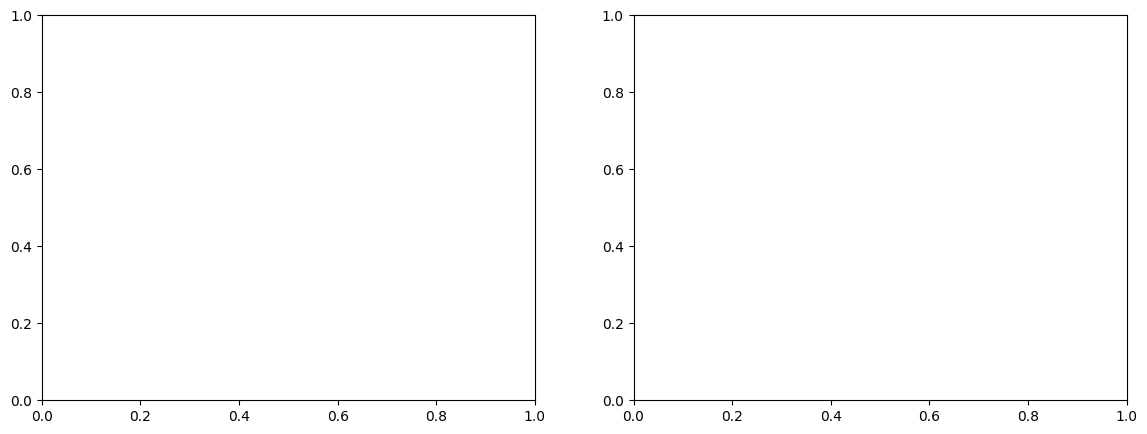

In [9]:
# Cell 9: Visualization

def moving_average(data, window=10):
    return np.convolve(data, np.ones(window)/window, mode='valid')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Per-hand rewards
if len(rewards_history) > 10:
    ma_rewards = moving_average(rewards_history, window=100)
    axes[0].plot(ma_rewards, alpha=0.8)
else:
    axes[0].plot(rewards_history)
axes[0].axvline(x=len(rewards_history)//2, color='r', linestyle='--', label='Opponent Switch')
axes[0].set_title('Per-Hand Reward (Moving Average)')
axes[0].set_xlabel('Hand')
axes[0].set_ylabel('Reward (BBs)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Per-session rewards
axes[1].plot(session_rewards, 'o-', markersize=4)
axes[1].axvline(x=len(session_rewards)//2, color='r', linestyle='--', label='Opponent Switch')
axes[1].set_title('Average Session Reward')
axes[1].set_xlabel('Session')
axes[1].set_ylabel('Avg Reward (BBs)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Cell 10: Evaluation Function

def evaluate_agent(agent: DRQNAgentWrapper, num_hands: int = 100, 
                   opponent_type: str = 'random') -> Dict:
    """Evaluate agent against a specific opponent type."""
    env = PokerKitGymEnv(num_players=2)
    
    opponents = {
        'maniac': ManiacAgent(),
        'nit': NitAgent(),
        'random': RandomAgent()
    }
    opponent = opponents[opponent_type]
    
    agent.start_new_session()
    env.reset_session()
    
    wins = 0
    losses = 0
    ties = 0
    total_reward = 0.0
    
    for hand in range(num_hands):
        obs, info = env.reset()
        done = False
        hand_reward = 0.0
        
        while not done:
            current_player = env.get_current_player()
            legal_actions = info['legal_actions']
            
            if current_player is None:
                break
            
            if current_player == env.agent_player_index:
                action = agent.select_action(obs, legal_actions, eval_mode=True)
            else:
                action = opponent.select_action(legal_actions)
            
            obs, reward, done, truncated, info = env.step(action)
            
            if current_player == env.agent_player_index:
                hand_reward = reward
        
        total_reward += hand_reward
        if hand_reward > 0:
            wins += 1
        elif hand_reward < 0:
            losses += 1
        else:
            ties += 1
    
    results = {
        'opponent': opponent_type,
        'hands_played': num_hands,
        'wins': wins,
        'losses': losses,
        'ties': ties,
        'win_rate': wins / num_hands,
        'total_reward': total_reward,
        'avg_reward': total_reward / num_hands
    }
    
    print(f"\n=== Evaluation vs {opponent_type.upper()} ===")
    print(f"Hands: {num_hands}")
    print(f"W/L/T: {wins}/{losses}/{ties}")
    print(f"Win Rate: {results['win_rate']:.1%}")
    print(f"Total Profit: {total_reward:.1f} BBs")
    print(f"Avg Profit/Hand: {results['avg_reward']:.2f} BBs")
    
    return results

# Evaluate against each opponent type
print("\nEvaluating trained agent...")
for opp in ['random', 'maniac', 'nit']:
    evaluate_agent(agent, num_hands=100, opponent_type=opp)

## Summary of Fixes

The original notebook had these issues:

1. **Epsilon decay too slow**: Decayed per session (not per hand), so after 20 sessions epsilon was still ~0.9
2. **Insufficient training**: Only 1,000 hands (20 sessions × 50 hands)
3. **High epsilon minimum**: 0.1 meant 10% random actions even after training

### Changes Made:

| Parameter | Before | After |
|-----------|--------|-------|
| `epsilon_min` | 0.1 | 0.05 |
| `epsilon_decay` | 0.995 (per session) | 0.9995 (per hand) |
| `num_sessions` | 20 | 100 |
| `hands_per_session` | 50 | 100 |
| **Total hands** | 1,000 | 10,000 |

With these changes, epsilon will decay to ~0.05 after about 6,000 hands, allowing the agent to actually exploit what it learned.